In [1]:
import os
import math


import numpy as np
 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import open_clip

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as T

from tqdm import tqdm
import pandas as pd
import cv2
from PIL import Image

import utilities

In [2]:
# get product 10k

def read_img(img_path, is_gray=False):
    mode = cv2.IMREAD_COLOR if not is_gray else cv2.IMREAD_GRAYSCALE
    img = cv2.imread(img_path, mode)
    if not is_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

class ProductDataset(Dataset):
    def __init__(self, 
                 img_dir, 
                 annotations_file, 
                 transform=None, 
                 final_transform=None, 
                 headers=None,
                 test_mode=False):
        self.data = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.final_transform = final_transform
        self.headers = {"img_path": "img_path", "product_id": "product_id"}
        if headers:
            self.headers = headers
        self.test_mode = test_mode
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data[self.headers["img_path"]][idx])
        
        img = read_img(img_path)
        if self.test_mode:
            x, y, w, h = self.data["bbox_x"][idx], self.data["bbox_y"][idx], \
                         self.data["bbox_w"][idx], self.data["bbox_h"][idx]
            img = img[y:y+h, x:x+w]
            
        
        if self.transform is not None:
            img = transform(image=img)["image"]
        
        if self.final_transform is not None:
            if isinstance(img, np.ndarray):
                img =  Image.fromarray(img)
            img = self.final_transform(img)
            
        product_id = self.data[self.headers["product_id"]][idx]
        return img, product_id
    
def get_final_transform():  
    final_transform = T.Compose([
            T.Resize(
                size=(224, 224), 
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True),
            T.ToTensor(), 
            T.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073), 
                std=(0.26862954, 0.26130258, 0.27577711)
            )
        ])
    return final_transform

@th.no_grad()
def extract_embeddings(model, dataloader, epoch=10, use_cuda=True):
    features = []
    product_id = []
    
    for _ in range(epoch):
        for imgs, p_id in tqdm(dataloader):
            if use_cuda:
                imgs = imgs.cuda()
            features.append(th.squeeze(model(imgs.half())).detach().cpu().numpy().astype(np.float32))
            product_id.append(th.squeeze(p_id).detach().cpu().numpy())


    return np.concatenate(features, axis=0), np.concatenate(product_id)

In [9]:
path1 =  f'/home/cemmi/Documents/aicrowd/G-Universal-CLIP/my_experiments/soup_slim_p10k_h_m_image_net_happy_whale_w_03.pt'
path2 = f'/home/cemmi/Documents/aicrowd/G-Universal-CLIP/my_experiments/ViT-H-14-laion2b_s32b_b79k-image_net-v2-p10k-h&m-amazon-Arcface(k=3)-All-Epoch(10)-Reduce_LR_0.1/model_epoch_2_mAP3_0.58_slim.pt'

In [10]:
backbone = open_clip.create_model_and_transforms('ViT-H-14', None)[0].visual
backbone.load_state_dict(th.load(path1))
backbone.half()
backbone.eval()

VisionTransformer(
  (conv1): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
  (patch_dropout): Identity()
  (ln_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0): ResidualAttentionBlock(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=1280, out_features=5120, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=5120, out_features=1280, bias=True)
        )
        (ls_2): Identity()
      )
      (1): ResidualAttentionBlock(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadA

In [11]:
final_transform = get_final_transform()
img_dir = "../development_test_data"
dataset_test = ProductDataset(img_dir, os.path.join(img_dir, "queries.csv"), None, final_transform, test_mode=True)
dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4)

dataset_train = ProductDataset(img_dir, os.path.join(img_dir, "gallery.csv"), None, final_transform)
dataloader_train = DataLoader(dataset_train, batch_size=512, num_workers=4)

img_dir = "../amazon_dataset_1"
headers = {"img_path": "path", "product_id": "id"}
dataset_test = ProductDataset(img_dir, os.path.join(img_dir, "query.csv"), None, final_transform, headers=headers)
dataloader_amazon_test = DataLoader(dataset_test, batch_size=512, num_workers=4)

dataset_train = ProductDataset(img_dir, os.path.join(img_dir, "gallery.csv"), None, final_transform, headers=headers)
dataloader_amazon_train = DataLoader(dataset_train, batch_size=512, num_workers=4)

In [12]:

@th.no_grad()
def compute_score_test_data(model):
    embeddings_query, labels_query = extract_embeddings(model, dataloader_test, 1)
    embeddings_gallery, labels_gallery = extract_embeddings(model, dataloader_train, 1)

    _, indices = utilities.get_similiarity_l2(embeddings_gallery, embeddings_query, 1000)


    indices = indices.tolist()
    labels_gallery = labels_gallery.tolist()
    labels_query = labels_query.tolist()

    preds = utilities.convert_indices_to_labels(indices, labels_gallery)
    score = utilities.map_per_set(labels_query, preds)
    
    return score

@th.no_grad()
def compute_score_amazon_data(model):
    embeddings_query, labels_query = extract_embeddings(model, dataloader_amazon_test, 1)
    embeddings_gallery, labels_gallery = extract_embeddings(model, dataloader_amazon_train, 1)

    _, indices = utilities.get_similiarity_l2(embeddings_gallery, embeddings_query, 1000)


    indices = indices.tolist()
    labels_gallery = labels_gallery.tolist()
    labels_query = labels_query.tolist()

    preds = utilities.convert_indices_to_labels(indices, labels_gallery)
    score = utilities.map_per_set(labels_query, preds)
    
    return score

In [13]:
n = 20
W = [i/n for i in range(0, n+1)]
m_ap_test = []
m_ap_amazon = []

with th.no_grad():
    for w in W:
        model = open_clip.create_model_and_transforms('ViT-H-14', None)[0].visual
        model.load_state_dict(th.load(path2))
        model.half()
        model.eval()

        for o, b in zip(model.parameters(), backbone.parameters()):
            o.data = w*o + (1 - w)*b

        model.cuda()
        #score_amazon = compute_score_amazon_data(model)
        score_amazon = 0
        score_test = compute_score_test_data(model)

        print(f'Weight {w} - test score {score_test} | amazon score {score_amazon}')
        m_ap_test.append(score_test)
        #m_ap_amazon.append(score_amazon)
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.10s/it]


Processing indices...
Finished processing indices, took 0.19469022750854492s
Weight 0.0 - test score 0.6214900947459087 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.12s/it]


Processing indices...
Finished processing indices, took 0.19409894943237305s
Weight 0.05 - test score 0.6210163652024117 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.11s/it]


Processing indices...
Finished processing indices, took 0.19318628311157227s
Weight 0.1 - test score 0.6224375538329026 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.13s/it]


Processing indices...
Finished processing indices, took 0.19133210182189941s
Weight 0.15 - test score 0.6225495262704566 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.12s/it]


Processing indices...
Finished processing indices, took 0.19185137748718262s
Weight 0.2 - test score 0.622248062015504 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.14s/it]


Processing indices...
Finished processing indices, took 0.19069290161132812s
Weight 0.25 - test score 0.6239362618432386 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.12s/it]


Processing indices...
Finished processing indices, took 0.19216513633728027s
Weight 0.3 - test score 0.6242635658914728 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.13s/it]


Processing indices...
Finished processing indices, took 0.19608664512634277s
Weight 0.35 - test score 0.6268130921619293 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.13s/it]


Processing indices...
Finished processing indices, took 0.19263792037963867s
Weight 0.4 - test score 0.6251507321274762 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.11s/it]


Processing indices...
Finished processing indices, took 0.1916208267211914s
Weight 0.45 - test score 0.6266063738156762 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.12s/it]


Processing indices...
Finished processing indices, took 0.19179844856262207s
Weight 0.5 - test score 0.6261584840654608 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.11s/it]


Processing indices...
Finished processing indices, took 0.19575834274291992s
Weight 0.55 - test score 0.6248923341946597 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.14s/it]


Processing indices...
Finished processing indices, took 0.19413423538208008s
Weight 0.6 - test score 0.6226959517657191 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.13s/it]


Processing indices...
Finished processing indices, took 0.193253755569458s
Weight 0.65 - test score 0.6237898363479759 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.11s/it]


Processing indices...
Finished processing indices, took 0.19272875785827637s
Weight 0.7 - test score 0.6228596037898363 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.11s/it]


Processing indices...
Finished processing indices, took 0.1924593448638916s
Weight 0.75 - test score 0.6220499569336779 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.12s/it]


Processing indices...
Finished processing indices, took 0.19493556022644043s
Weight 0.8 - test score 0.6230490956072352 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.12s/it]


Processing indices...
Finished processing indices, took 0.19246530532836914s
Weight 0.85 - test score 0.620594315245478 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.13s/it]


Processing indices...
Finished processing indices, took 0.19254493713378906s
Weight 0.9 - test score 0.6175193798449613 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.14s/it]


Processing indices...
Finished processing indices, took 0.19192981719970703s
Weight 0.95 - test score 0.6143755383290268 | amazon score 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.14s/it]


Processing indices...
Finished processing indices, took 0.19298553466796875s
Weight 1.0 - test score 0.6136520241171404 | amazon score 0


In [13]:
model = backbone
model.cuda()
score_amazon = compute_score_amazon_data(model)
score_test = compute_score_test_data(model)
score_amazon, score_test

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.43s/it]


Processing indices...
Finished processing indices, took 0.15860867500305176s


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.37s/it]


Processing indices...
Finished processing indices, took 0.2096538543701172s


(0.9039156626506024, 0.6153229974160207)

In [20]:
score_amazon

0.901004016064257

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline

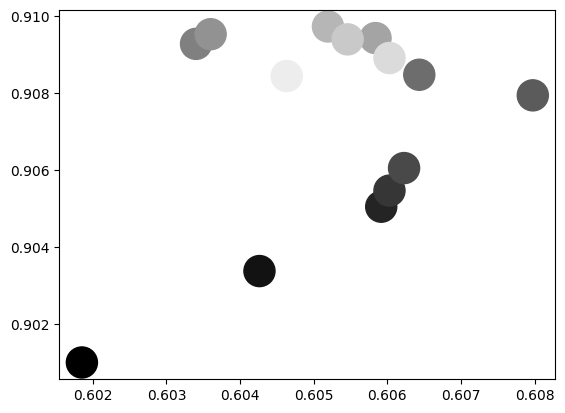

In [32]:
plt.scatter(m_ap_test, m_ap_amazon, c=list(range(len(m_ap_amazon))), s=500, cmap='gray')
plt.show()

In [ ]:
plt.plot(W, m_ap)

In [14]:
with th.no_grad():
    model = open_clip.create_model_and_transforms('ViT-H-14', None)[0].visual
    model.load_state_dict(th.load(path2))
    model.half()
    model.eval()

    w = 0.35

    for o, b in zip(model.parameters(), backbone.parameters()):
        o.data = w*o + (1 - w)*b

    th.save(model.state_dict(), 
               f'/home/cemmi/Documents/aicrowd/G-Universal-CLIP/my_experiments/soup_slim_p10k_h_m_amazon_image_net_happy_whale.pt')
